See 'swallow classification bandpass.ipynb' for preprocessing.

In [1]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\07_18_25\extracted signals'
class_folders = os.listdir(data_path)

# Feature Extraction
I got some of these features and functions from this link: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

In [2]:
import numpy as np

# mean absolute value
def mav(data):
    return np.mean(np.abs(data), axis=0)

# root mean square
def rms(data):
    return np.sqrt(np.mean(data**2,axis=0))  
    
# wavelength
def wavelength(data):
    return np.sum(np.abs(np.diff(data)), axis=0)
    
# zero crossing rate
def zcr(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0) / (len(data)-1)

# variance
def var(data):
    return np.var(data, axis=0)

# sum of absolute differences between consecutive samples
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

# mean frequency
def mean_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    return np.sum(freqs * spectrum) / np.sum(spectrum)

# median frequency
def median_freq(data, fs=500):
    data = data - np.mean(data)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    cumulative = np.cumsum(spectrum)
    total = cumulative[-1]
    med_idx = np.searchsorted(cumulative, total / 2)
    return freqs[med_idx]

# peak frequency
def peak_freq(data, fs=500):
    data = data - np.mean(data)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    peak_idx = np.argmax(spectrum)
    return freqs[peak_idx]

In [3]:
df = pd.DataFrame()

class_map = {}
i = 0

sampling_rate = 500 # in Hz
window_seconds = 0.15 # in seconds
window_size = int(window_seconds * sampling_rate)

for class_name in os.listdir(data_path):
    if class_name == 'oral prep 0':
        continue
        
    class_path = os.path.join(data_path, class_name)
    class_str = class_name.rstrip('.txt')
    parts = class_str.split()
    volume = parts[-1]
    substance = ' '.join(parts[:-1])
    
    for sample_name in os.listdir(class_path):
        sample_df = pd.read_csv(os.path.join(data_path, class_name, sample_name), delimiter = ",", header = None)

        # rectification
        sample_df = sample_df.abs()

        # rms smoothing
        sample_df = sample_df.rolling(window=window_size).apply(rms, raw=True)
        sample_df = sample_df.dropna()
        
        sample_df.columns = [f"channel {i+1}" for i in range(sample_df.shape[1])]
        if substance not in class_map:
            class_map[substance] = i
            i += 1
        
        sample_df['substance'] = substance
        sample_df['volume'] = volume
        sample_df_grouped = sample_df.groupby(['substance', 'volume'])
        
        features_df = sample_df_grouped.agg(['max', mav, rms, wavelength, var, abs_diffs_signal, mean_freq, median_freq, peak_freq])
        df = pd.concat([df, features_df])

df.reset_index(inplace=True)
sample_df

,channel 1,channel 2,channel 3,channel 4,channel 5,channel 6,channel 7,channel 8,channel 9,channel 10,...,channel 15,channel 16,channel 17,channel 18,channel 19,channel 20,channel 21,channel 22,substance,volume
74,11.411011,14.085540,8.352037,14.539810,9.975685,6.604589,11.291065,7.854395,15.460014,9.443514,...,15.915842,9.171689,26.254581,776.590049,624.778310,8106.745504,4147.530028,5403.395476,yogurt,20
75,11.227618,13.648364,8.438387,14.322803,9.790426,6.621332,11.289231,7.855203,15.044835,9.649147,...,15.928089,9.169195,25.894428,776.642121,624.849556,8088.818290,4287.109982,5453.103337,yogurt,20
76,11.155764,13.537919,8.701743,14.366280,9.734263,6.856331,11.301237,7.954291,14.893416,9.845696,...,16.088284,9.174186,25.623238,776.759491,624.920794,8049.711879,4400.812652,5507.441753,yogurt,20
77,11.149486,13.527129,8.700134,14.388082,9.729937,6.893511,11.313184,7.970334,14.894915,9.838515,...,16.173865,9.180123,25.331917,776.941231,624.998346,8012.224993,4491.913327,5566.439436,yogurt,20
78,11.104442,13.546098,8.655936,14.376755,9.760362,6.879946,11.308537,7.956591,14.868938,9.814394,...,16.107645,9.179850,25.131068,777.271626,625.069567,7988.951704,4553.050260,5626.583570,yogurt,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.419745,4.887460,2.372991,4.553604,3.418946,1.197284,3.545201,2.057309,5.437497,2.852241,...,4.540969,2.640292,5.018576,771.366773,631.602170,8213.375757,1002.149689,1857.239529,yogurt,20
996,4.372283,4.865665,2.353427,4.546700,3.412867,1.202602,3.525543,2.098071,5.404039,2.830600,...,4.551814,2.652681,4.989706,771.471224,631.466019,8125.083466,980.399918,1858.716403,yogurt,20
997,4.357378,4.879035,2.361453,4.574985,3.435116,1.201684,3.529196,2.098953,5.388990,2.841730,...,4.605766,2.651597,4.969620,771.523312,631.420382,8036.162600,970.756406,1860.402824,yogurt,20
998,4.355769,4.900372,2.363487,4.591022,3.444210,1.202307,3.517324,2.093389,5.402513,2.841025,...,4.654902,2.647208,4.915656,771.575364,631.381096,7941.904390,967.520542,1862.649010,yogurt,20


In [4]:
df

substance volume  channel 1                                                \
                            max        mav        rms  wavelength         var   
0       apple     10  31.491611  13.269799  15.983017  121.064531   79.369260   
1       apple     10  44.138337  13.145008  17.403641  117.505624  130.095476   
2       apple     10  37.322908  13.577676  17.053714  119.996187  106.475852   
3       apple     10  59.070049  15.893624  21.570193  160.878567  212.665947   
4       apple     10  43.687753  15.732191  19.653157  148.868249  138.744764   
..        ...    ...        ...        ...        ...         ...         ...   
318    yogurt     20  30.567810  13.175806  15.965831  111.069365   81.305895   
319    yogurt     20  38.339321  15.148103  18.661716  138.720397  118.794595   
320    yogurt     20  38.012117  14.441241  17.704473  132.296123  104.898900   
321    yogurt     20  34.253892  14.297142  16.952415  129.387561   82.976118   
322    yogurt     20  42.320230  18.192366  21.434507  166.894565  128.475886   

                                            ... channel 21    channel 22  \
    abs_diffs_signal mean_freq median_freq  ...  peak_freq           max   
0         121.064531  0.172133    0.539957  ...   0.539957  10254.067421   
1         117.505624  0.228705    0.539957  ...   1.079914   7284.127035   
2         119.996187  0.174337    0.539957  ...   0.539957  10689.107727   
3         160.878567  0.332281    0.539957  ...   1.619870  11258.437547   
4         148.868249  0.182366    0.539957  ...   0.539957  10885.543931   
..               ...       ...         ...  ...        ...           ...   
318       111.069365  0.135827    0.539957  ...   0.539957   9977.774234   
319       138.720397  0.162559    0.539957  ...   0.539957  12546.572653   
320       132.296123  0.177841    0.539957  ...   0.539957   7971.611966   
321       129.387561  0.181728    0.539957  ...   0.539957   9324.434424   
322       166.894565  0.157619    0.539957  ...   1.619870   9726.578295   

                                                                            \
             mav          rms    wavelength           var abs_diffs_signal   
0    4160.525055  4797.580885  42344.937861  5.706814e+06     42344.937861   
1    4732.225093  5082.750706  35483.547913  3.440400e+06     35483.547913   
2    5253.063454  5745.841460  41318.822622  5.420018e+06     41318.822622   
3    6172.775416  6633.529734  51258.260069  5.900560e+06     51258.260069   
4    6398.996538  6920.252785  46493.145332  6.942742e+06     46493.145332   
..           ...          ...           ...           ...              ...   
318  3873.296022  4452.540820  38110.847811  4.822698e+06     38110.847811   
319  4783.514686  5549.885568  44689.314091  7.919217e+06     44689.314091   
320  5237.853551  5449.926943  39949.527254  2.266594e+06     39949.527254   
321  4703.579645  5261.086038  41878.047649  5.555365e+06     41878.047649   
322  4558.438117  4877.981834  38954.661174  3.015349e+06     38954.661174   

                                     
    mean_freq median_freq peak_freq  
0    0.223320    1.079914  0.539957  
1    0.101430    0.539957  0.539957  
2    0.139225    0.539957  0.539957  
3    0.186458    1.619870  1.619870  
4    0.106020    0.539957  0.539957  
..        ...         ...       ...  
318  0.243938    1.079914  1.079914  
319  0.259170    1.619870  1.619870  
320  0.110066    2.159827  0.539957  
321  0.177157    1.079914  0.539957  
322  0.188178    2.159827  1.619870  

[323 rows x 200 columns]

In [5]:
print(class_map)

{'apple': 0, 'dry swallow': 1, 'jelly': 2, 'milk': 3, 'redu oral prep': 4, 'water': 5, 'yogurt': 6}


In [6]:
df['substance'] = df['substance'].map(class_map)
df

substance volume  channel 1                                                \
                            max        mav        rms  wavelength         var   
0           0     10  31.491611  13.269799  15.983017  121.064531   79.369260   
1           0     10  44.138337  13.145008  17.403641  117.505624  130.095476   
2           0     10  37.322908  13.577676  17.053714  119.996187  106.475852   
3           0     10  59.070049  15.893624  21.570193  160.878567  212.665947   
4           0     10  43.687753  15.732191  19.653157  148.868249  138.744764   
..        ...    ...        ...        ...        ...         ...         ...   
318         6     20  30.567810  13.175806  15.965831  111.069365   81.305895   
319         6     20  38.339321  15.148103  18.661716  138.720397  118.794595   
320         6     20  38.012117  14.441241  17.704473  132.296123  104.898900   
321         6     20  34.253892  14.297142  16.952415  129.387561   82.976118   
322         6     20  42.320230  18.192366  21.434507  166.894565  128.475886   

                                            ... channel 21    channel 22  \
    abs_diffs_signal mean_freq median_freq  ...  peak_freq           max   
0         121.064531  0.172133    0.539957  ...   0.539957  10254.067421   
1         117.505624  0.228705    0.539957  ...   1.079914   7284.127035   
2         119.996187  0.174337    0.539957  ...   0.539957  10689.107727   
3         160.878567  0.332281    0.539957  ...   1.619870  11258.437547   
4         148.868249  0.182366    0.539957  ...   0.539957  10885.543931   
..               ...       ...         ...  ...        ...           ...   
318       111.069365  0.135827    0.539957  ...   0.539957   9977.774234   
319       138.720397  0.162559    0.539957  ...   0.539957  12546.572653   
320       132.296123  0.177841    0.539957  ...   0.539957   7971.611966   
321       129.387561  0.181728    0.539957  ...   0.539957   9324.434424   
322       166.894565  0.157619    0.539957  ...   1.619870   9726.578295   

                                                                            \
             mav          rms    wavelength           var abs_diffs_signal   
0    4160.525055  4797.580885  42344.937861  5.706814e+06     42344.937861   
1    4732.225093  5082.750706  35483.547913  3.440400e+06     35483.547913   
2    5253.063454  5745.841460  41318.822622  5.420018e+06     41318.822622   
3    6172.775416  6633.529734  51258.260069  5.900560e+06     51258.260069   
4    6398.996538  6920.252785  46493.145332  6.942742e+06     46493.145332   
..           ...          ...           ...           ...              ...   
318  3873.296022  4452.540820  38110.847811  4.822698e+06     38110.847811   
319  4783.514686  5549.885568  44689.314091  7.919217e+06     44689.314091   
320  5237.853551  5449.926943  39949.527254  2.266594e+06     39949.527254   
321  4703.579645  5261.086038  41878.047649  5.555365e+06     41878.047649   
322  4558.438117  4877.981834  38954.661174  3.015349e+06     38954.661174   

                                     
    mean_freq median_freq peak_freq  
0    0.223320    1.079914  0.539957  
1    0.101430    0.539957  0.539957  
2    0.139225    0.539957  0.539957  
3    0.186458    1.619870  1.619870  
4    0.106020    0.539957  0.539957  
..        ...         ...       ...  
318  0.243938    1.079914  1.079914  
319  0.259170    1.619870  1.619870  
320  0.110066    2.159827  0.539957  
321  0.177157    1.079914  0.539957  
322  0.188178    2.159827  1.619870  

[323 rows x 200 columns]

# Single Label Classification
### Substance

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

x = df.drop(columns=['volume', 'substance'])
y = df['substance']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258,)


C:\Users\chloe\AppData\Local\Temp\ipykernel_27676\3354761790.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# joint accuracies
models = []
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1scores = []

def train_and_plot_model(model, model_name):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    model_confusion_matrix = confusion_matrix(y_test, y_pred)

    models.append(model_name)
    model_accuracies.append(accuracy * 100)
    model_precisions.append(precision * 100)
    model_recalls.append(recall * 100)
    model_f1scores.append(f1score * 100)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1score:.4f}')
    print('----------------------------')
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(model_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### SVM
The lines below are taken from here: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

Accuracy: 0.9077
Precision: 0.9142
Recall: 0.9077
F1 score: 0.9074
----------------------------


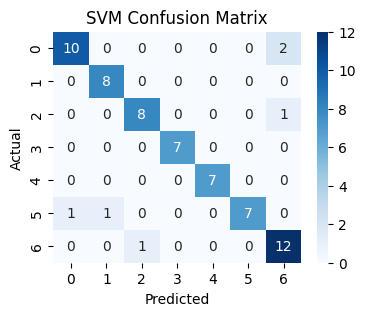

In [33]:
svm_model = svm.SVC(kernel='linear')
train_and_plot_model(svm_model, 'SVM')

### KNN

Accuracy: 0.8615
Precision: 0.8841
Recall: 0.8615
F1 score: 0.8584
----------------------------


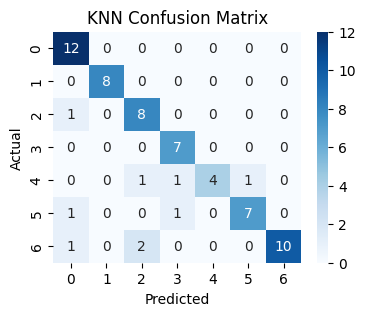

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
train_and_plot_model(knn_model, 'KNN')

### Decision Tree

Accuracy: 0.7692
Precision: 0.7837
Recall: 0.7692
F1 score: 0.7591
----------------------------


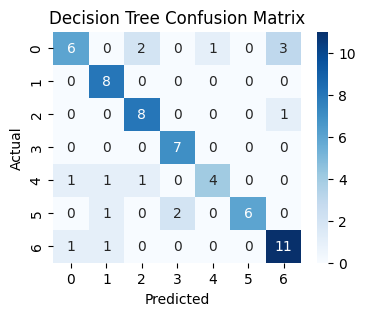

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
train_and_plot_model(dt_model, 'Decision Tree')

### Naive Bayes

Accuracy: 0.6769
Precision: 0.7197
Recall: 0.6769
F1 score: 0.6464
----------------------------


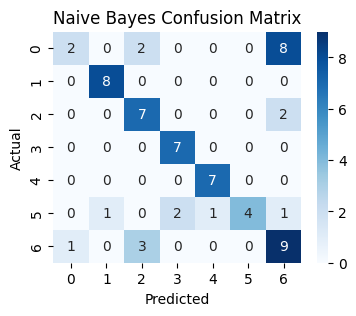

In [36]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
train_and_plot_model(nb_model, 'Naive Bayes')

### Logistic Regression

Accuracy: 0.9231
Precision: 0.9272
Recall: 0.9231
F1 score: 0.9225
----------------------------


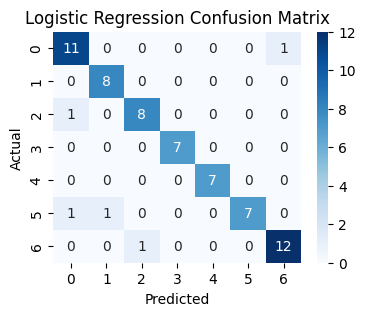

In [37]:
from sklearn.linear_model import LogisticRegression

regression_model = LogisticRegression()
train_and_plot_model(regression_model, 'Logistic Regression')

### Gradient Boosting

Accuracy: 0.8462
Precision: 0.8475
Recall: 0.8462
F1 score: 0.8462
----------------------------


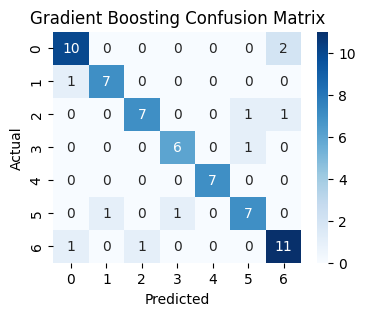

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
train_and_plot_model(gb_model, 'Gradient Boosting')

### Model Comparison

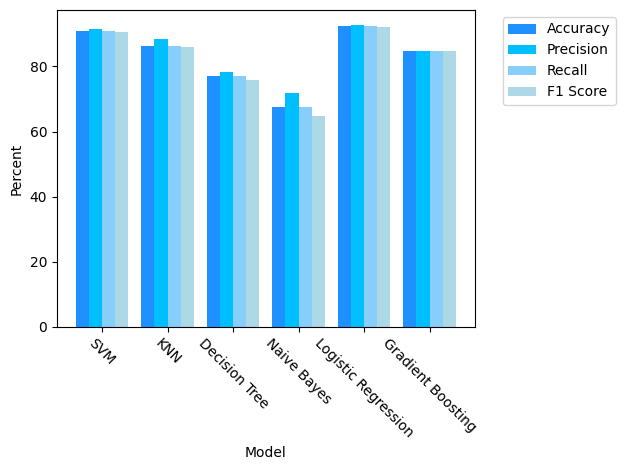

In [39]:
x = np.arange(len(models))  
width = 0.2                

plt.bar(x - 1.5*width, model_accuracies, width, label='Accuracy', color='dodgerblue')
plt.bar(x - 0.5*width, model_precisions, width, label='Precision', color='deepskyblue')
plt.bar(x + 0.5*width, model_recalls, width, label='Recall', color='lightskyblue')
plt.bar(x + 1.5*width, model_f1scores, width, label='F1 Score', color='lightblue')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(x, labels=models, rotation=-45)
plt.xlabel('Model')
plt.ylabel('Percent')

plt.tight_layout()
plt.show()

### Volume

In [40]:
# accuracy plot
models = []
model_accuracies = []
model_precisions = []
model_recalls = []
model_f1scores = []

x = df.drop(columns=['volume', 'substance'])
y = df['volume']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258,)


C:\Users\chloe\AppData\Local\Temp\ipykernel_27676\1694633448.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


Accuracy: 0.8615
Precision: 0.8653
Recall: 0.8615
F1 score: 0.8596
----------------------------


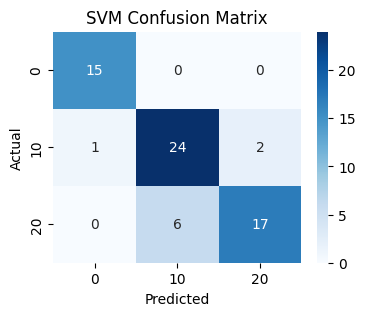

In [41]:
train_and_plot_model(svm_model, 'SVM')

Accuracy: 0.8769
Precision: 0.8874
Recall: 0.8769
F1 score: 0.8777
----------------------------


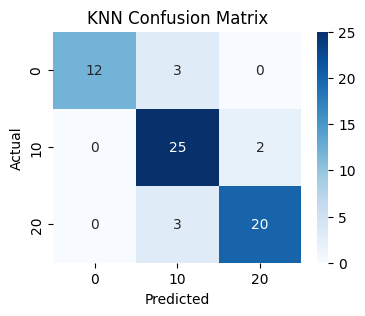

In [42]:
train_and_plot_model(knn_model, 'KNN')

Accuracy: 0.8308
Precision: 0.8357
Recall: 0.8308
F1 score: 0.8315
----------------------------


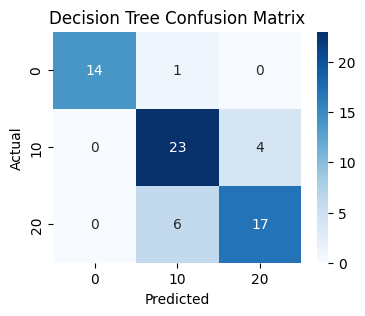

In [43]:
train_and_plot_model(dt_model, 'Decision Tree')

Accuracy: 0.7385
Precision: 0.7348
Recall: 0.7385
F1 score: 0.7294
----------------------------


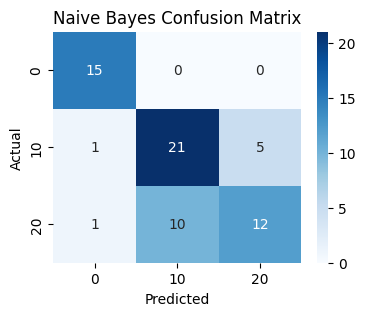

In [44]:
train_and_plot_model(nb_model, 'Naive Bayes')

Accuracy: 0.8462
Precision: 0.8632
Recall: 0.8462
F1 score: 0.8465
----------------------------


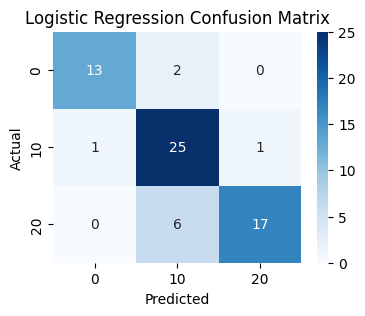

In [45]:
train_and_plot_model(regression_model, 'Logistic Regression')

Accuracy: 0.9231
Precision: 0.9233
Recall: 0.9231
F1 score: 0.9229
----------------------------


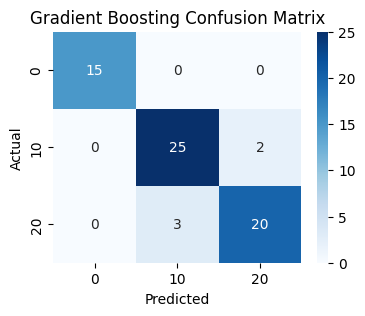

In [46]:
train_and_plot_model(gb_model, 'Gradient Boosting')

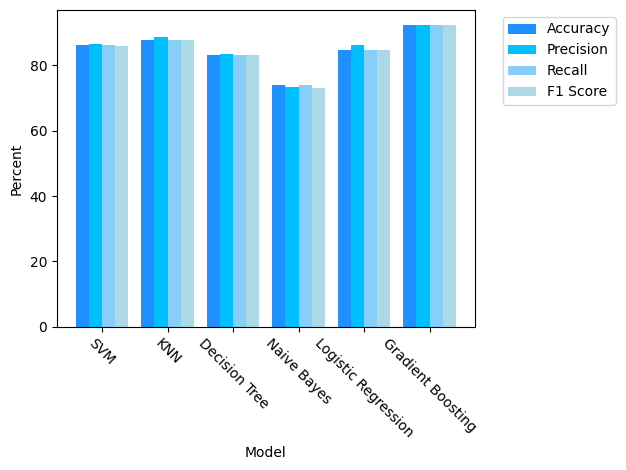

In [47]:
x = np.arange(len(models))  
width = 0.2                

plt.bar(x - 1.5*width, model_accuracies, width, label='Accuracy', color='dodgerblue')
plt.bar(x - 0.5*width, model_precisions, width, label='Precision', color='deepskyblue')
plt.bar(x + 0.5*width, model_recalls, width, label='Recall', color='lightskyblue')
plt.bar(x + 1.5*width, model_f1scores, width, label='F1 Score', color='lightblue')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(x, labels=models, rotation=-45)
plt.xlabel('Model')
plt.ylabel('Percent')

plt.tight_layout()
plt.show()

# Multi Label Classification

In [48]:
label_names = ['Substance', 'Volume']

# accuracies
models = []
model_exact_accuracies = [] # predicts both labels right

def train_and_plot_multioutput_model(model, model_name, cm=True):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    # Exact match accuracy (all labels correct)
    exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

    # Per-label accuracy
    per_label_accuracy = (y_test == y_pred).mean(axis=0)
    average_label_accuracy = per_label_accuracy.mean()

    models.append(model_name)
    model_exact_accuracies.append(exact_match_accuracy * 100)

    print(model_name)
    print(f'Exact Match Accuracy: {exact_match_accuracy:.4f}')
    print(f'Average Per-Label Accuracy: {average_label_accuracy:.4f}')
    print(f'Per-Label Accuracies: {per_label_accuracy.values if hasattr(per_label_accuracy, "values") else per_label_accuracy}')
    print('----------------------------')

    # Confusion matrices for each label
    if cm == True:
        for i, col in enumerate(y_test.columns):
            cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix, {label_names[i]}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

In [49]:
x = df.drop(columns=['volume', 'substance'])
y = df[['substance', 'volume']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(258, 198)
(258, 2)


C:\Users\chloe\AppData\Local\Temp\ipykernel_27676\437239220.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


In [50]:
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(svm_model)
train_and_plot_multioutput_model(model, 'SVM', cm=False)

model = MultiOutputClassifier(knn_model)
train_and_plot_multioutput_model(model, 'KNN', cm=False)

model = MultiOutputClassifier(dt_model)
train_and_plot_multioutput_model(model, 'Decision Tree', cm=False)

model = MultiOutputClassifier(nb_model)
train_and_plot_multioutput_model(model, 'Naive Bayes', cm=False)

model = MultiOutputClassifier(regression_model)
train_and_plot_multioutput_model(model, 'Linear Regression', cm=False)

model = MultiOutputClassifier(gb_model)
train_and_plot_multioutput_model(model, 'Gradient Boosting', cm=False)

SVM
Exact Match Accuracy: 0.8000
Average Per-Label Accuracy: 0.8846
Per-Label Accuracies: [0.90769231 0.86153846]
----------------------------
KNN
Exact Match Accuracy: 0.8462
Average Per-Label Accuracy: 0.8692
Per-Label Accuracies: [0.86153846 0.87692308]
----------------------------
Decision Tree
Exact Match Accuracy: 0.6000
Average Per-Label Accuracy: 0.7692
Per-Label Accuracies: [0.72307692 0.81538462]
----------------------------
Naive Bayes
Exact Match Accuracy: 0.5231
Average Per-Label Accuracy: 0.7077
Per-Label Accuracies: [0.67692308 0.73846154]
----------------------------
Linear Regression
Exact Match Accuracy: 0.8000
Average Per-Label Accuracy: 0.8846
Per-Label Accuracies: [0.92307692 0.84615385]
----------------------------
Gradient Boosting
Exact Match Accuracy: 0.8308
Average Per-Label Accuracy: 0.8846
Per-Label Accuracies: [0.84615385 0.92307692]
----------------------------


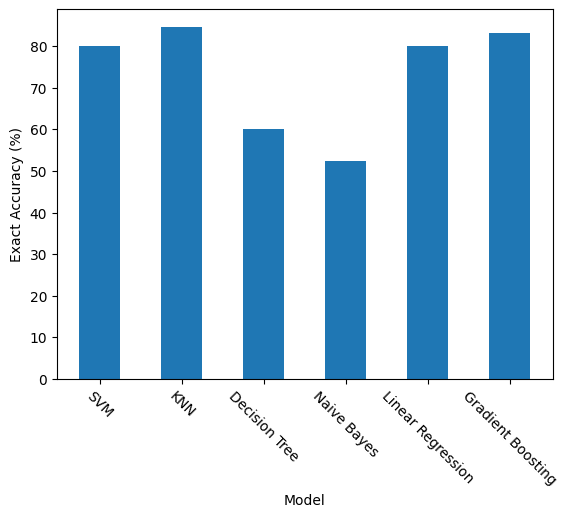

In [51]:
plt.bar(models, model_exact_accuracies, width=0.5)

plt.xticks(rotation=-45)
plt.xlabel('Model')
plt.ylabel('Exact Accuracy (%)')

plt.show()

In [52]:
import csv

with open('multioutput_smoothed_accuracies.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(model_exact_accuracies)

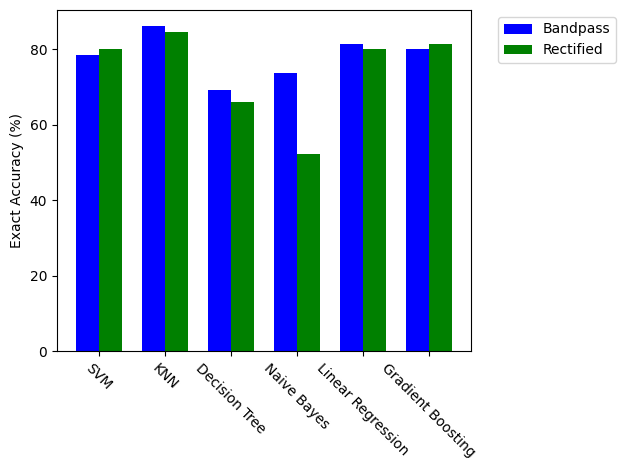

In [30]:
bandpass_accuracies_df = pd.read_csv('multioutput_bandpass_accuracies.csv', header=None)
bandpass_accuracies = bandpass_accuracies_df.iloc[0].tolist()

rectified_accuracies_df = pdf.read_csv('multioutput_rectified_accuracies.csv', header=None)
rectified_accuracies = rectified_accuracies_df.iloc[0].tolist()

x = np.arange(len(models))  # [0, 1, 2]
width = 0.25  # width of each bar

# Plot bars side by side
plt.bar(x - width, bandpass_accuracies, width, label='Bandpass', color='blue')
plt.bar(x, model_exact_accuracies, width, label='Rectified', color='green')
plt.bar(x + widt, model_exact_accuracies, width, label='Rectified', color='green')

# Add labels
plt.xticks(x, models, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()